In [1]:
from IPython.core.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from astropy.io import ascii

from auxiliary import *
import warnings
import astropy

display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Notebook structure

The notebook consists of four classes:

- catalogueProcessing
    - Used to perform queries and crossmatches
- Astrometry
    - Currently hosts functions for 
        - generating histograms
        - fitting gaussians
    - If HDbscan is implemented, it would go here.
- Photometry
    - Will have methods for making photometric cuts
- Visualization
    - Has methods for plotting, including
        - Plotting single columns
        - Plotting sources overlayed on an image
        - Plotting a gaussian fitted to a histogram generated from
          an arbitrary axis.
    - Will have method for plotting photometric cuts over the appropriate diagram






When catalogProcessing is instantiated, it queries gaia, 2mass, and allwise. This class also provides the ability to query any catalog availible from IRSA. __[More info here.](https://irsa.ipac.caltech.edu/docs/program_interface/TAP.html)__

Parallax for the cluster is optional and has units of milliarcseconds. If given, the radius is assumed to be physical (in pc), otherwise the radius is assumed to be angular (in degrees).

In [2]:
# Define region of interest parameters
ra_cen = "03h47m24s" # hour angle
dec_cen = "+24d07m00s" # degrees
#plx = 1.8481 # milliarcseconds, optional
rad = 1 # pc if plx is given, degrees if it is not

#coords = str(ra_cen) + "+" + str(dec_cen)

# Instantiates catalogProcessing:
cat_pr = catalogProcessing(ra_cen, dec_cen, radius=rad)

# Builds the full data table:
full_table = cat_pr.gaia
d = 1000 / full_table['parallax']
d.name = "radial_distance"
d.unit="pc"
full_table.add_column(d)
full_table.rename_column("ra", "gaia_ra")
full_table.rename_column("dec", "gaia_dec")
#full_table = cat_pr.generate_full_table(gen_small_table=True)
#full_table = Table.read('Ge117data.dat',format='ascii')

#print(full_table['w1mpro'])
#print(full_table['w2mpro'])
#print(full_table['w3mpro'])
#print(full_table['w4mpro'])

# Instantiates the Visualization and Photometry classes
vis = Visualization(full_table, ra_cen, dec_cen)
phot = Photometry(full_table)

# Generates diagnostic error plots:
#  proper motion, right ascension
#vis.plot_error('pmra')
#  proper motion, declination
#vis.plot_error('pmdec')
#  parallax
#vis.plot_error('parallax')

Querying Gaia...
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Done querying Gaia!

Querying 2MASS...
Done querying 2MASS!

Querying AllWISE...
Done querying AllWISE!



Below cell generates a full table consisting of all sources in gaia, 2mass, and allwise at 1pc around the search coordinates (as specified upon instantiation of catalogueProcessing). If a source wasn't crossmatched with a particular catalogue, the column values of this catalogue will be masked.

set gen_small_table to False to return a table with all columns from all three surveys

In [3]:
# Generates diagnostic plots of ra, dec, parallax, proper motion, and others.
#vis.plot_diagnostics()
#vis.plot("variability","phot_g_mean_mag",invert_y=True)

Below cell crossmatches the gaia table with the 2mass table. The xmatch radius is determined by looking at the errors of respective match (nearest neighbour) and selecting only objects that are closer than the combined error radii.

The method returns a list of indicies and distances that associates objects in catalogue1 with those in catalogue2.

In [4]:
print(len(full_table['gaia_ra']))

27226


plot_image_overlay gets images from the list of surveys passed to it and plots the sources from the list aux.Visualization was instantiated with, in this case gaia, superimposed on them.

I'll have to do something about overcrowding when there are many sources.

In [5]:
#%matplotlib notebook
#vis.plot_images(['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22'], cats_to_plot=["gaia"])
#https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [6]:
%matplotlib notebook
#vis.plot_hist("parallax", "Parallax")
#vis.plot_hist("pmra", "pm RA [mas/yr]")
#vis.plot_hist("pmdec", "pm Dec [mas/yr]")

In [7]:
#vis.plot("gaia_ra", "gaia_dec", squared=True, invert_y=True)
#vis.plot("pmra", "pmdec",xlim=(-30,30),ylim=(-30,30), squared=True, invert_y=True)
#vis.plot("parallax", "parallax_error", xlim=(0,6))


In [8]:
%matplotlib inline
#redder, not_redder = phot.keep_reddest()
#vis_redder = Visualization(redder, ra_cen, dec_cen)
#vis_redder.plot_diagnostics()

In [9]:
#likely_disks, not_likely_disks = phot.keep_likely_disks()
#vis_likely_disks = Visualization(likely_disks, ra_cen, dec_cen)
#vis_likely_disks.plot_diagnostics()

The next cell runs HDBSCAN on the full_table input. It's set to return not more than 20 clusters - arbitrary, I'm still trying to figure out what works for this. It looks to me like the approach of using min_cluster_size may not be effective, but not using it currently gives me in excess of 200 clusters for this dataset, so another solution is needed.

On the plus side, even before applying any photometric cuts, the Pleiades are identified in orange in the plot below, which tells me that the algorithm is robust enough to tolerate some non-ideal behavior in terms of passing it data.

Organizing clustering data...
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'gaia_ra', 'ra_error', 'gaia_dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'p

<IPython.core.display.Javascript object>


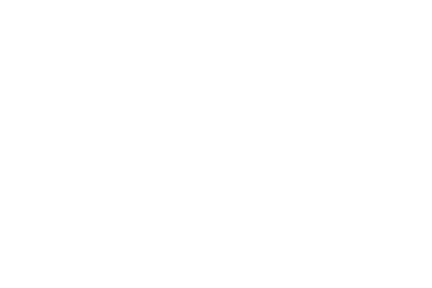

plotting cluster0


<IPython.core.display.Javascript object>


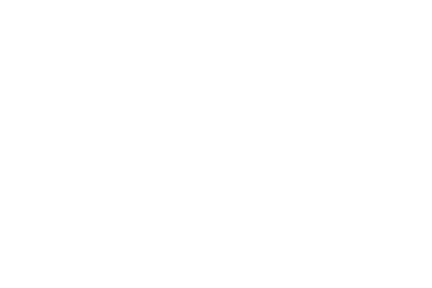

plotting cluster1


<IPython.core.display.Javascript object>


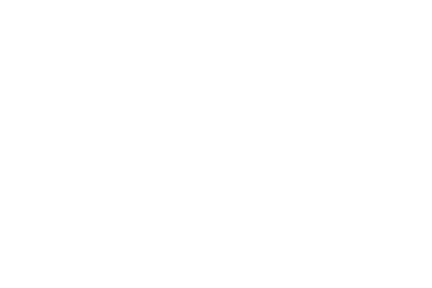

plotting cluster2


<IPython.core.display.Javascript object>


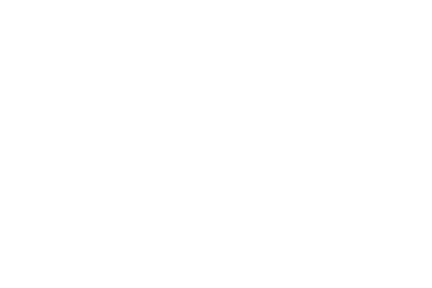

plotting cluster3


<IPython.core.display.Javascript object>


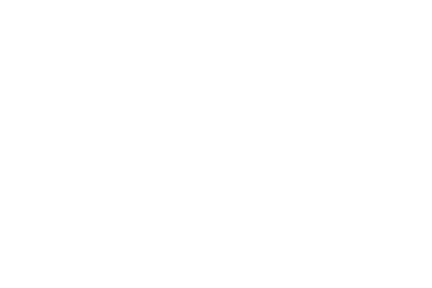

plotting cluster4


<IPython.core.display.Javascript object>


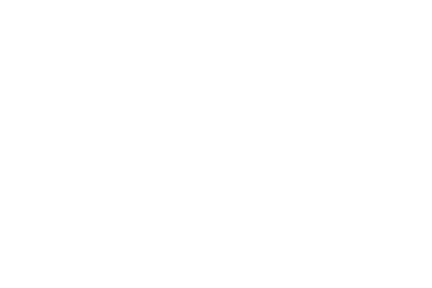

plotting cluster5


<IPython.core.display.Javascript object>


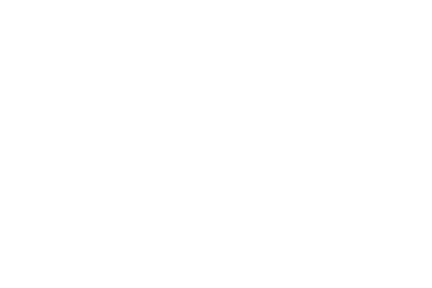

plotting cluster6


<IPython.core.display.Javascript object>


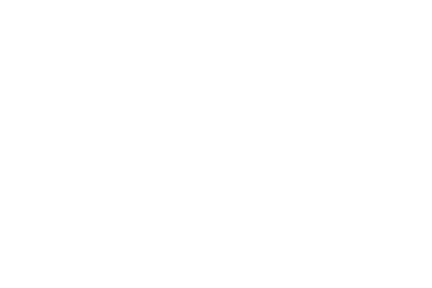

plotting cluster7


<IPython.core.display.Javascript object>


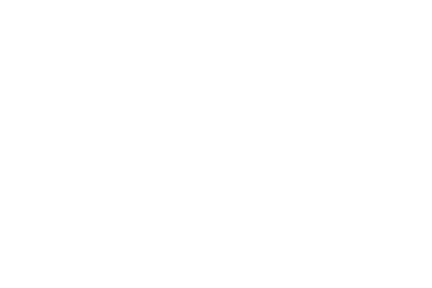

plotting cluster8


<IPython.core.display.Javascript object>


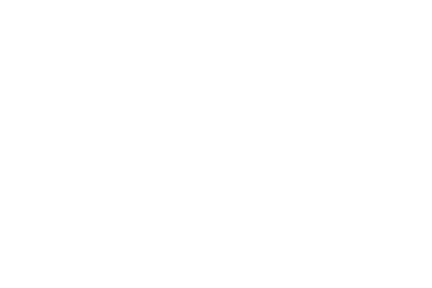

plotting cluster9


<IPython.core.display.Javascript object>


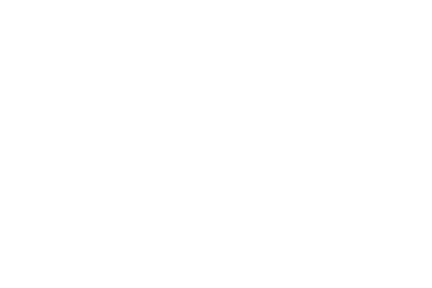

plotting cluster10


<IPython.core.display.Javascript object>


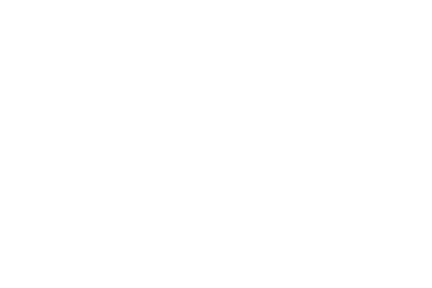

plotting cluster11


<IPython.core.display.Javascript object>


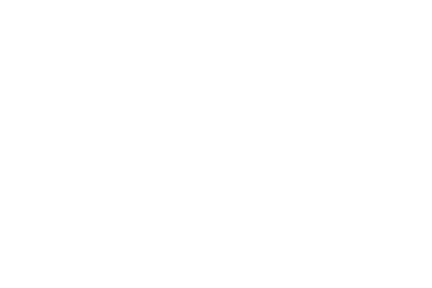

plotting cluster12


<IPython.core.display.Javascript object>


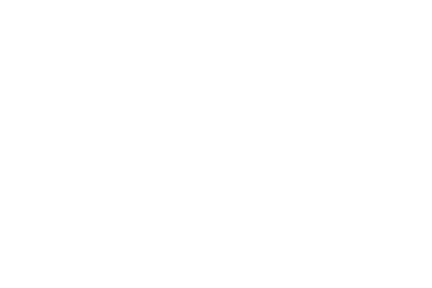

plotting cluster13


<IPython.core.display.Javascript object>


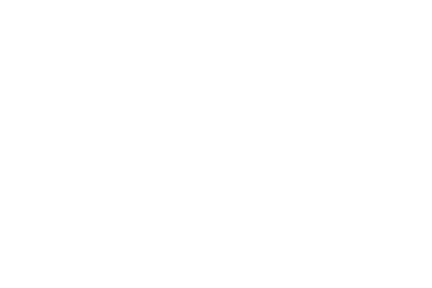

plotting cluster14


<IPython.core.display.Javascript object>


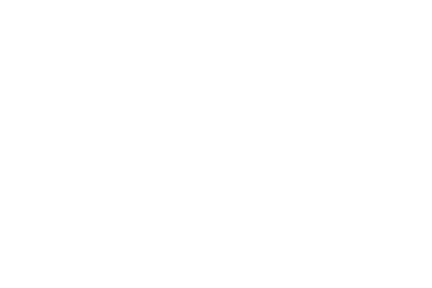

plotting cluster15


<IPython.core.display.Javascript object>


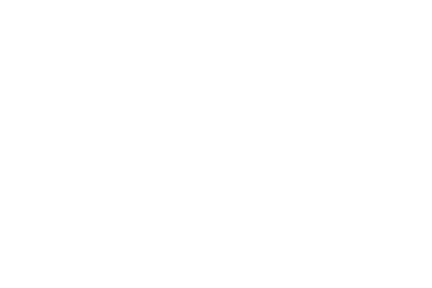

plotting cluster16


<IPython.core.display.Javascript object>


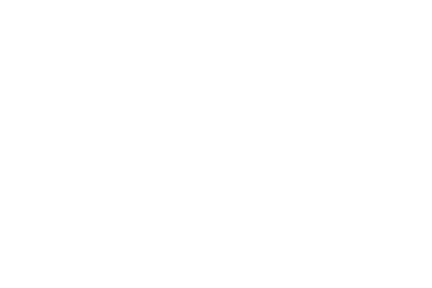

plotting cluster17


<IPython.core.display.Javascript object>


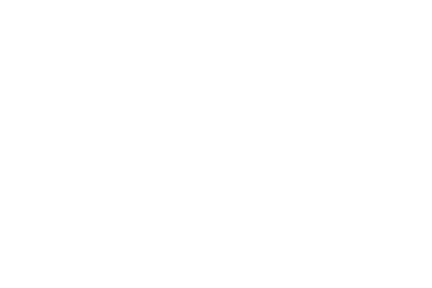

plotting cluster18


<IPython.core.display.Javascript object>


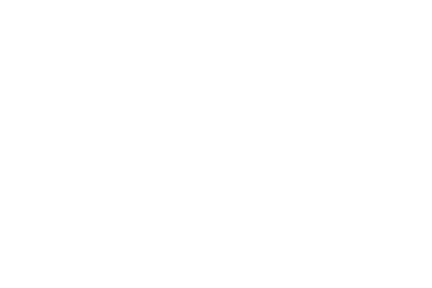

plotting cluster19


<IPython.core.display.Javascript object>


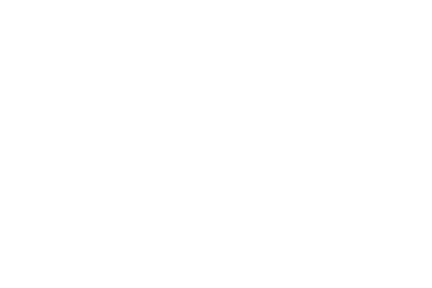

plotting cluster20


<IPython.core.display.Javascript object>


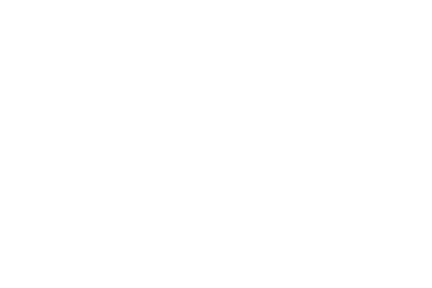

plotting cluster21


<IPython.core.display.Javascript object>


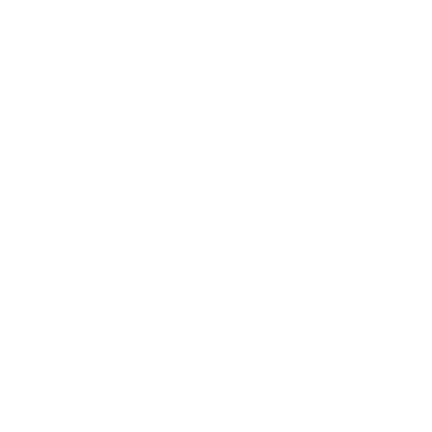

<IPython.core.display.Javascript object>


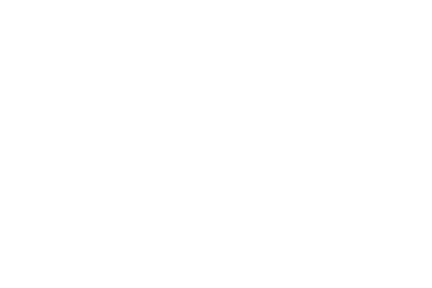

plotting cluster0


<IPython.core.display.Javascript object>


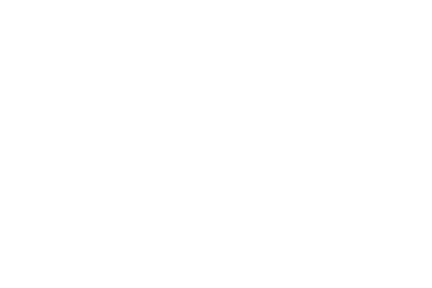

plotting cluster1


<IPython.core.display.Javascript object>


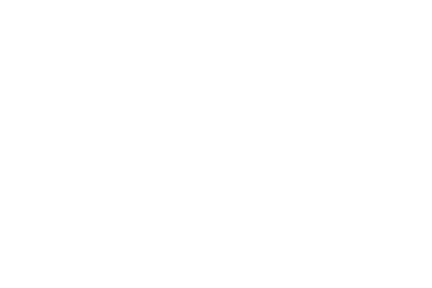

plotting cluster2


<IPython.core.display.Javascript object>


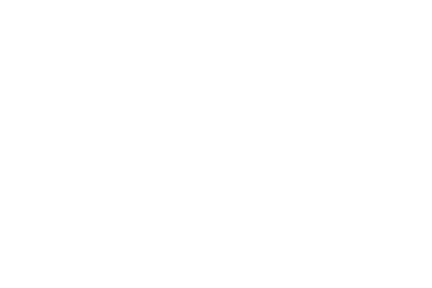

plotting cluster3


<IPython.core.display.Javascript object>


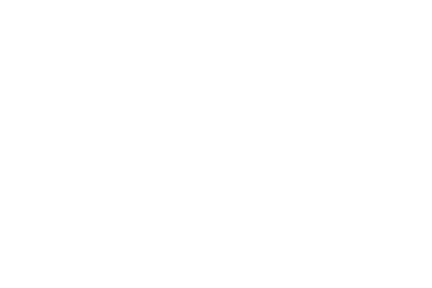

plotting cluster4


<IPython.core.display.Javascript object>


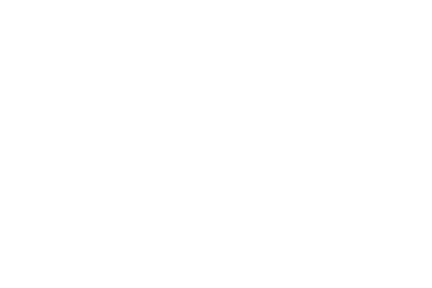

plotting cluster5


<IPython.core.display.Javascript object>


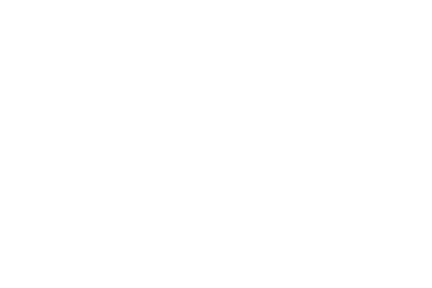

plotting cluster6


<IPython.core.display.Javascript object>


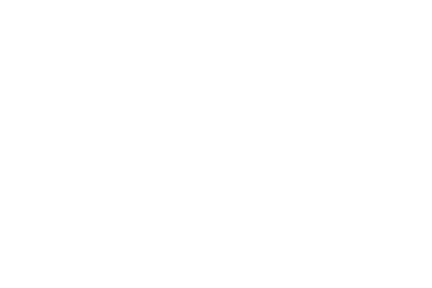

plotting cluster7


<IPython.core.display.Javascript object>


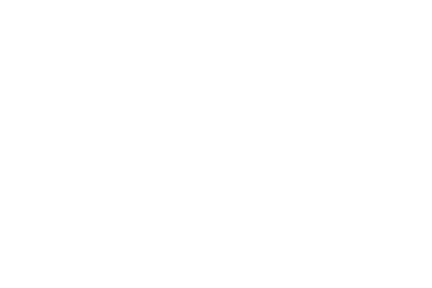

plotting cluster8


<IPython.core.display.Javascript object>


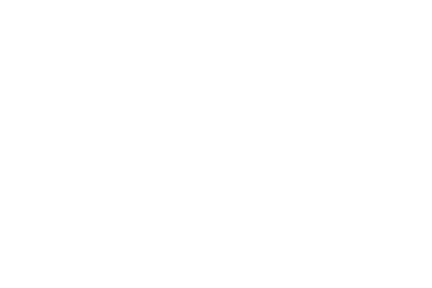

plotting cluster9


<IPython.core.display.Javascript object>


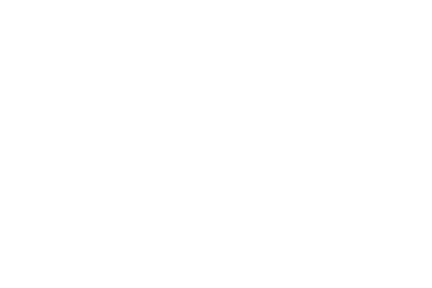

plotting cluster10


<IPython.core.display.Javascript object>


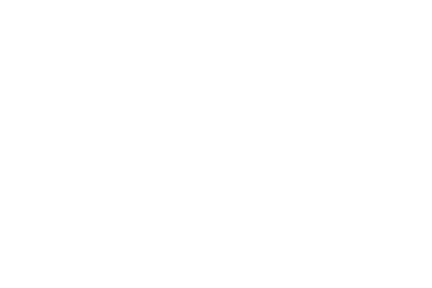

plotting cluster11


<IPython.core.display.Javascript object>


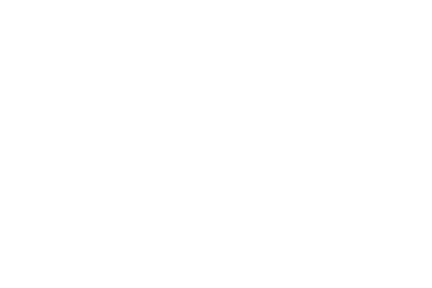

plotting cluster12


<IPython.core.display.Javascript object>


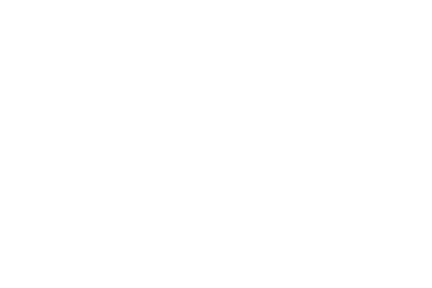

plotting cluster13


<IPython.core.display.Javascript object>


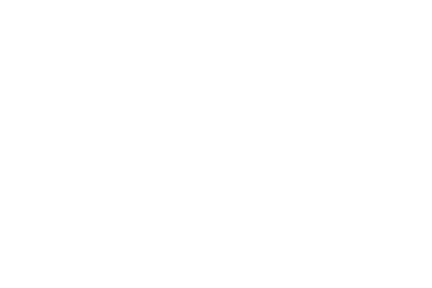

plotting cluster14


<IPython.core.display.Javascript object>


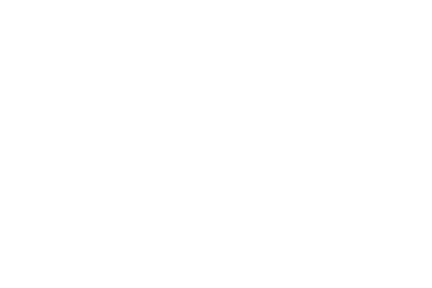

plotting cluster15


<IPython.core.display.Javascript object>


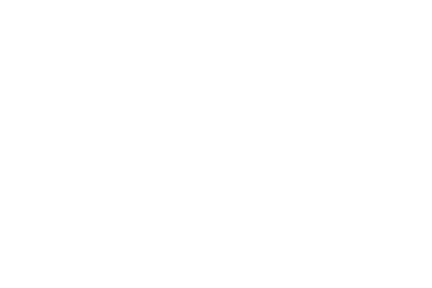

plotting cluster16


<IPython.core.display.Javascript object>


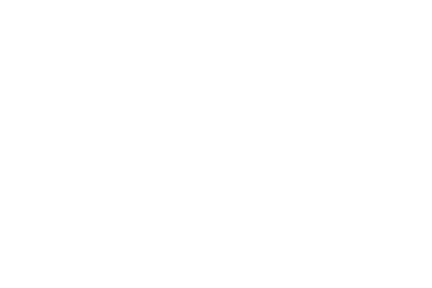

plotting cluster17


<IPython.core.display.Javascript object>


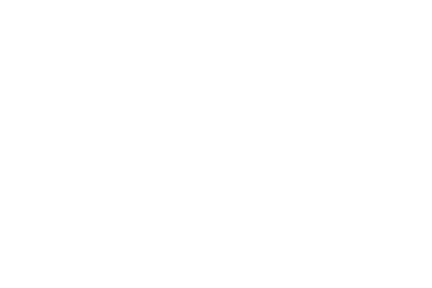

plotting cluster18


<IPython.core.display.Javascript object>


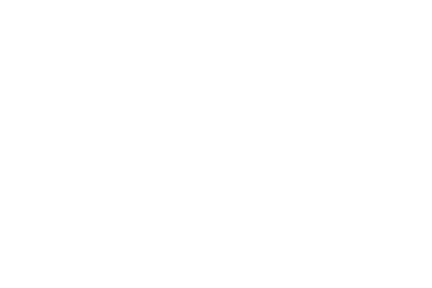

plotting cluster19


<IPython.core.display.Javascript object>


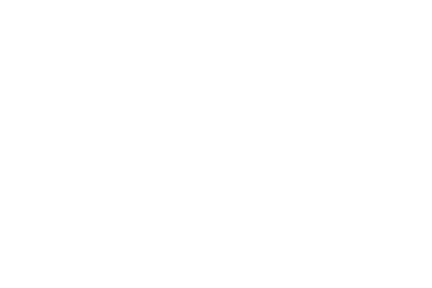

plotting cluster20


<IPython.core.display.Javascript object>


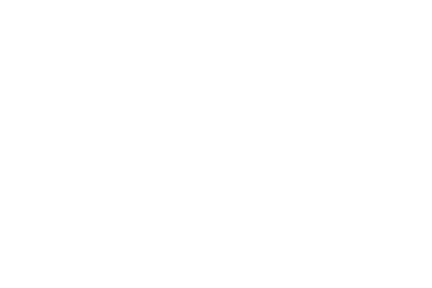

plotting cluster21


<IPython.core.display.Javascript object>


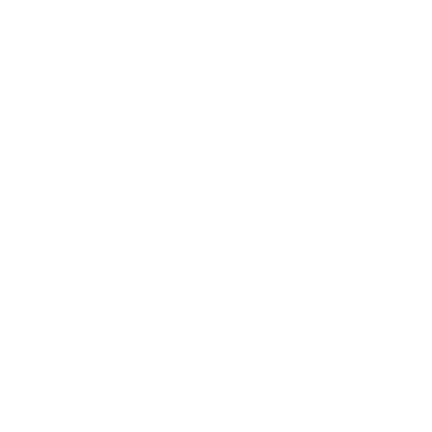

1


<IPython.core.display.Javascript object>


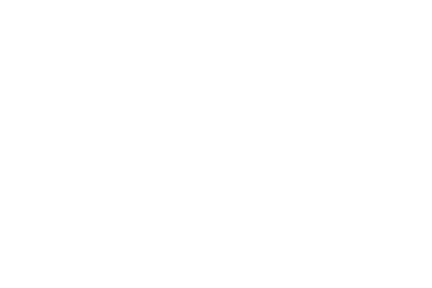

<IPython.core.display.Javascript object>


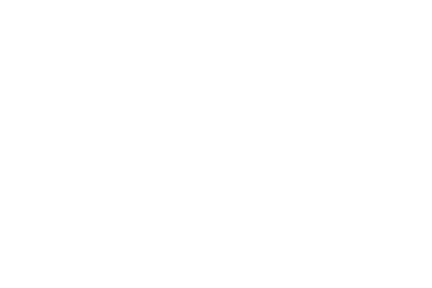

<IPython.core.display.Javascript object>


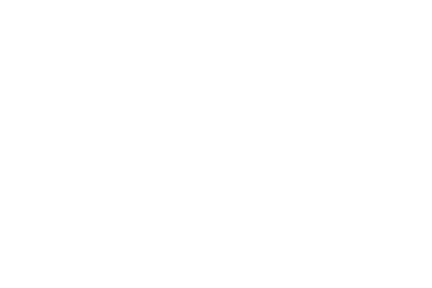

<IPython.core.display.Javascript object>


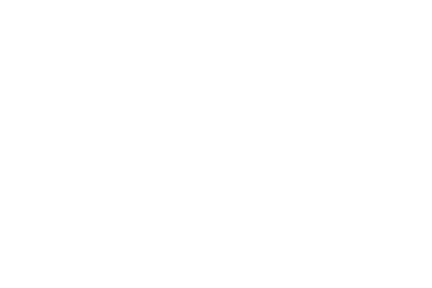

<IPython.core.display.Javascript object>


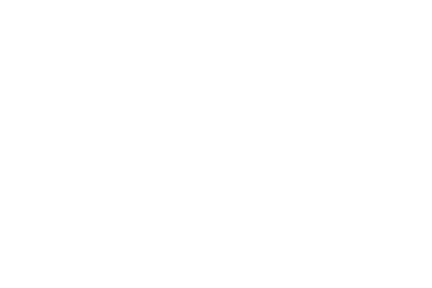

<IPython.core.display.Javascript object>


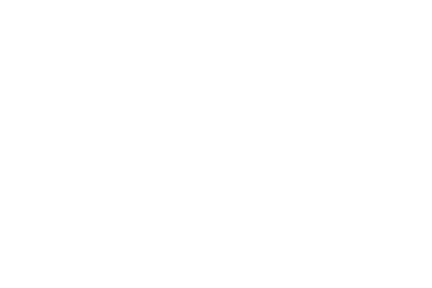

<IPython.core.display.Javascript object>


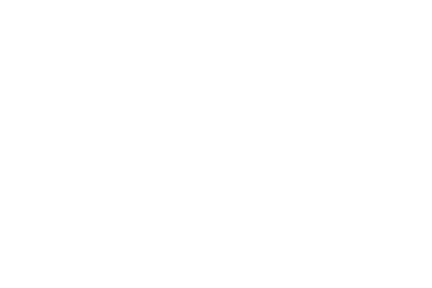

<IPython.core.display.Javascript object>


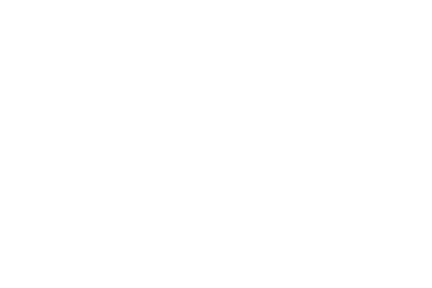

<IPython.core.display.Javascript object>


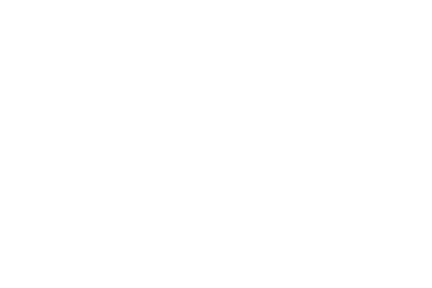

<IPython.core.display.Javascript object>


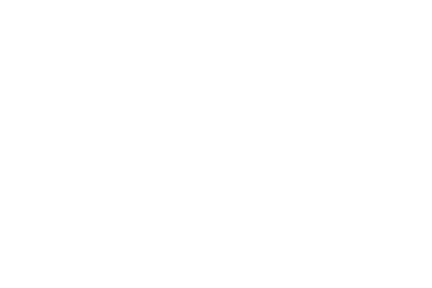

<IPython.core.display.Javascript object>


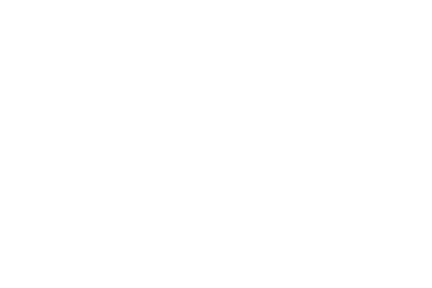

<IPython.core.display.Javascript object>


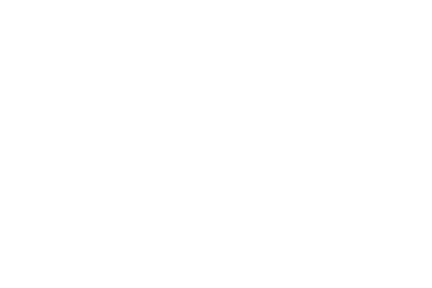

<IPython.core.display.Javascript object>


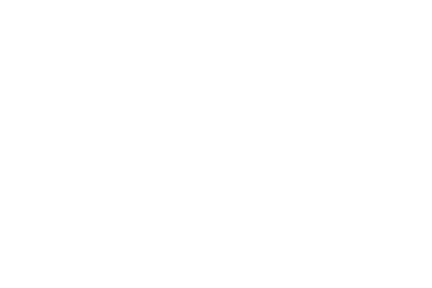

<IPython.core.display.Javascript object>


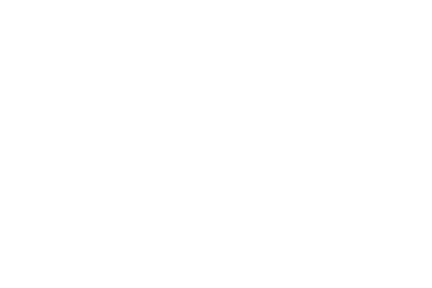

<IPython.core.display.Javascript object>


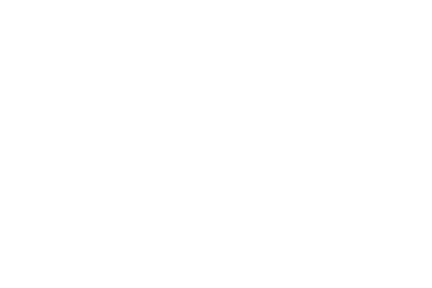

<IPython.core.display.Javascript object>


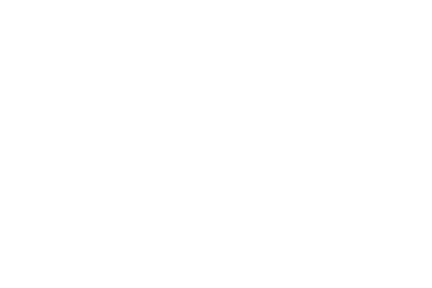

<IPython.core.display.Javascript object>


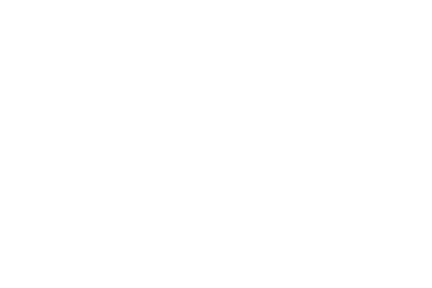

<IPython.core.display.Javascript object>


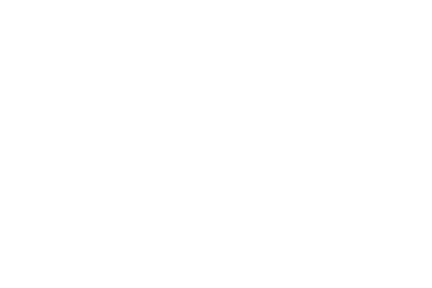

<IPython.core.display.Javascript object>


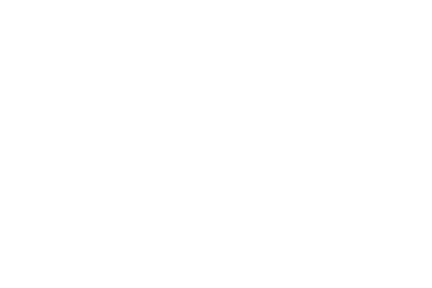

<IPython.core.display.Javascript object>


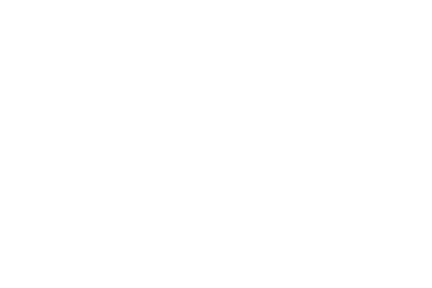

<IPython.core.display.Javascript object>


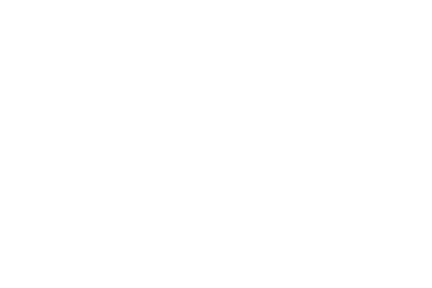

<IPython.core.display.Javascript object>


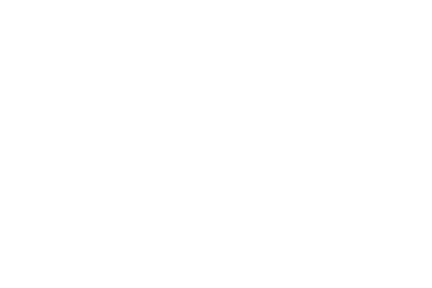

<IPython.core.display.Javascript object>


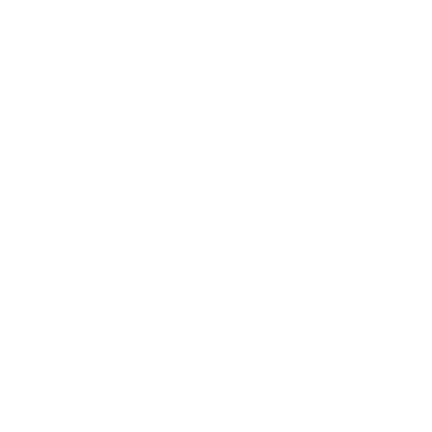

<IPython.core.display.Javascript object>


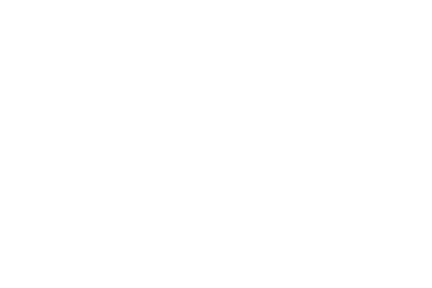

<IPython.core.display.Javascript object>


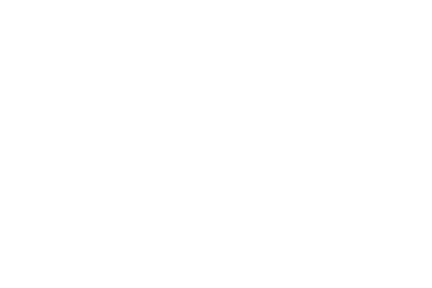

<IPython.core.display.Javascript object>


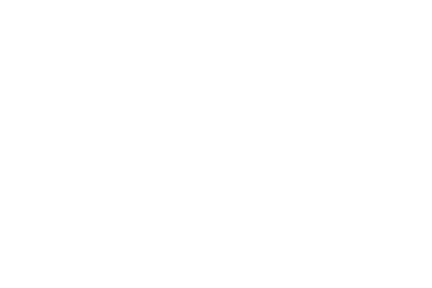

<IPython.core.display.Javascript object>


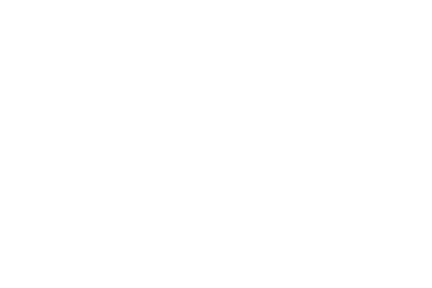

<IPython.core.display.Javascript object>


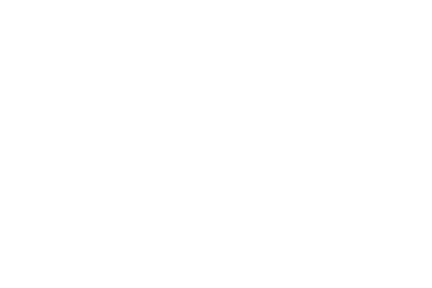

<IPython.core.display.Javascript object>


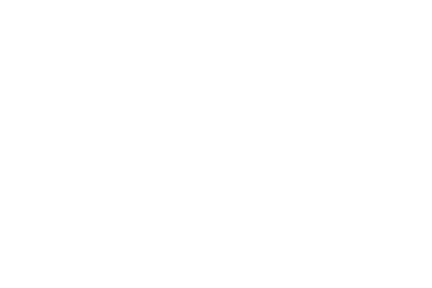

<IPython.core.display.Javascript object>


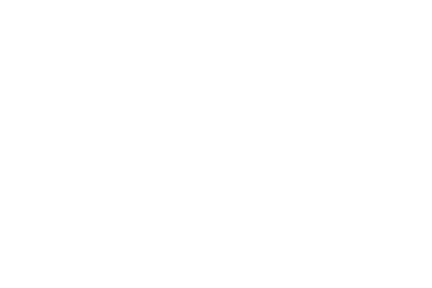

<IPython.core.display.Javascript object>


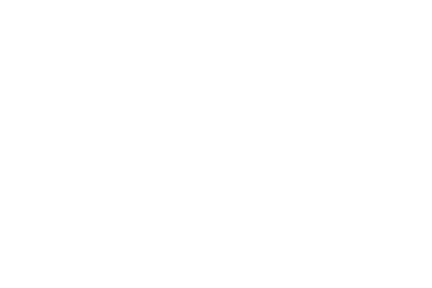

<IPython.core.display.Javascript object>


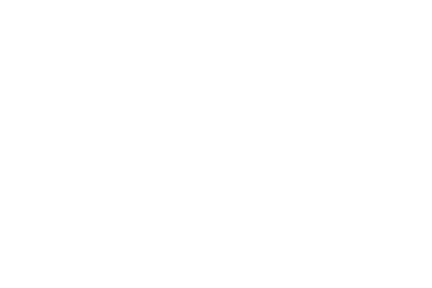

<IPython.core.display.Javascript object>


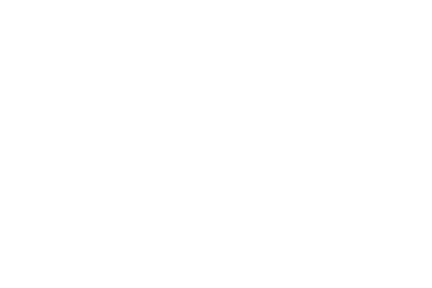

<IPython.core.display.Javascript object>


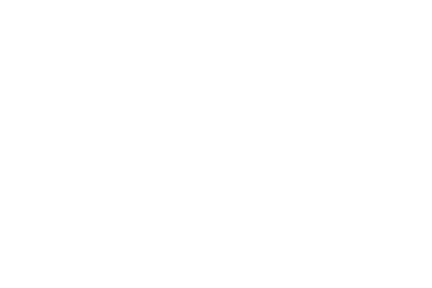

<IPython.core.display.Javascript object>


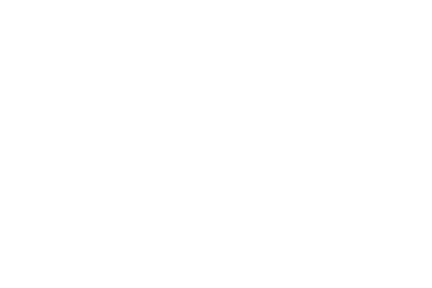

<IPython.core.display.Javascript object>


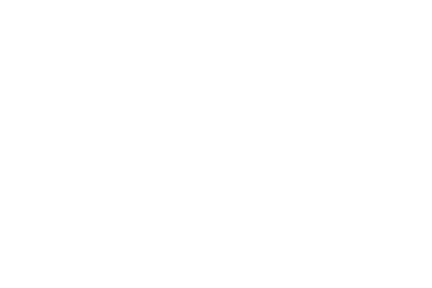

<IPython.core.display.Javascript object>


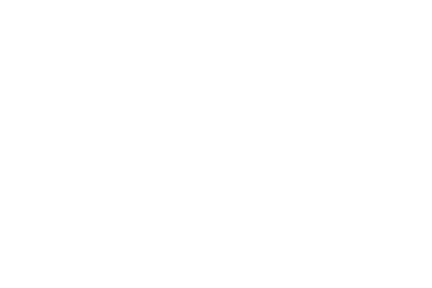

<IPython.core.display.Javascript object>


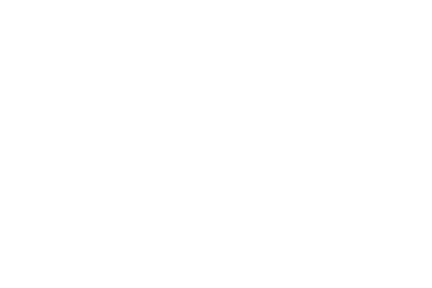

<IPython.core.display.Javascript object>


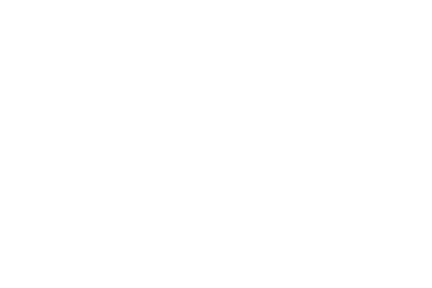

<IPython.core.display.Javascript object>


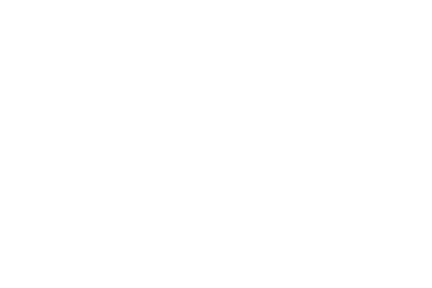

<IPython.core.display.Javascript object>


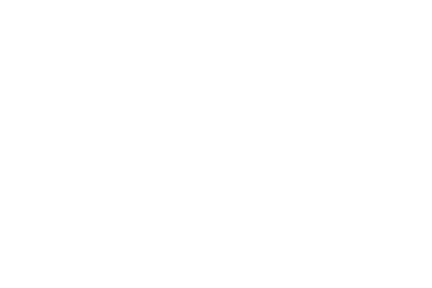

<IPython.core.display.Javascript object>


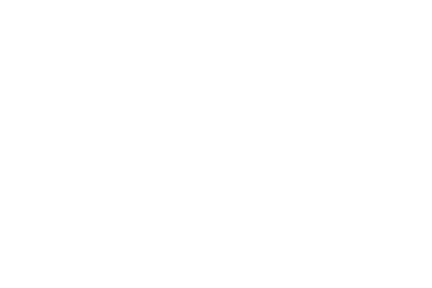

<IPython.core.display.Javascript object>


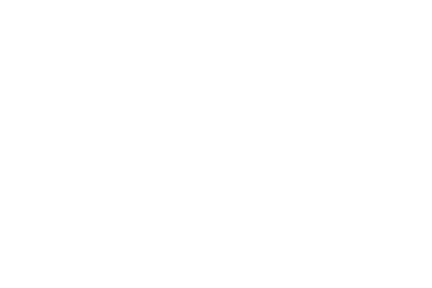

<IPython.core.display.Javascript object>


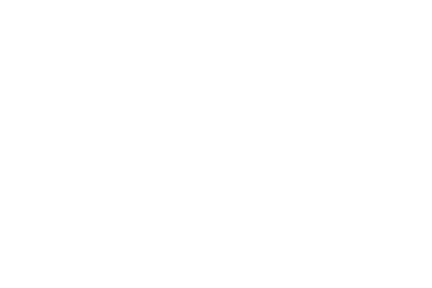

<IPython.core.display.Javascript object>


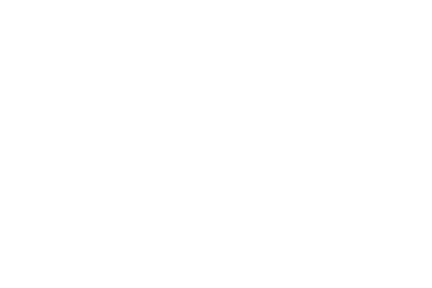

<IPython.core.display.Javascript object>


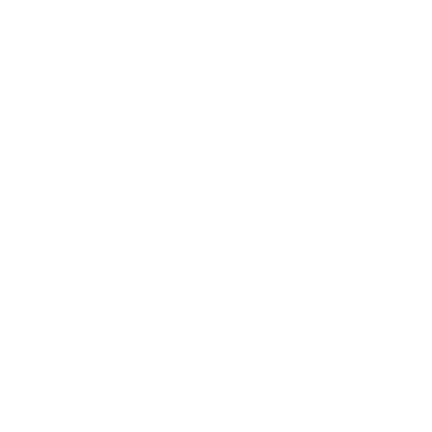

In [17]:
ok_parallax_table, _ = phot.apply_cut("self.full_table['parallax'] > 0")
candidates_table, cluster_membership_full = cat_pr.identify_clusters(ok_parallax_table, ["gaia_ra", "gaia_dec", "pmra","pmdec", "radial_distance"])
vis.plot_clusters(candidates_table, cluster_membership_full, column_A="pmra", column_B="pmdec", xlim=(-100,100),ylim=(-100,100))
vis.plot_clusters(candidates_table, cluster_membership_full, column_A="gaia_ra", column_B="gaia_dec")
#vis.plot_clusters(candidates_table, cluster_membership_full, column_A="pmra", column_B="radial_distance")
#print(candidates_table)
#print(cluster_membership_full)
clusters_data = cat_pr.process_clusters(candidates_table, cluster_membership_full, ["pmra","pmdec","radial_distance"])
print(len(clusters_data))

best pmra: 20.037140011555856
68 percent interval: 18.966418642266667 to 21.08955845145548


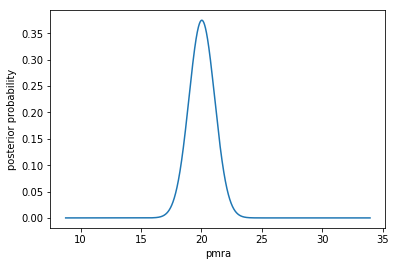

best pmdec: -45.409981039557984
68 percent interval: -46.70731975657048 to -44.12382627700249


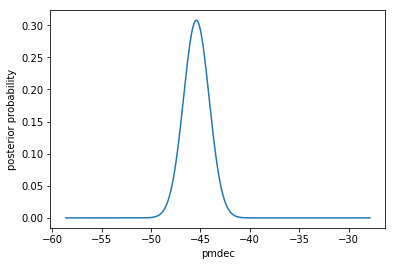

best parallax: 7.316877905221449
68 percent interval: 7.153928471191329 to 7.478213978518597


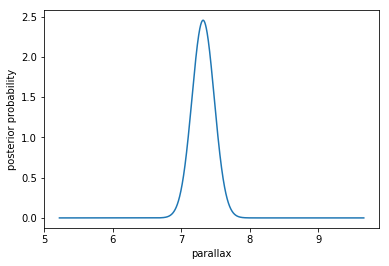

best ra: 56.723605938593394
68 percent interval: 56.377557432563385 to 57.06437701642687


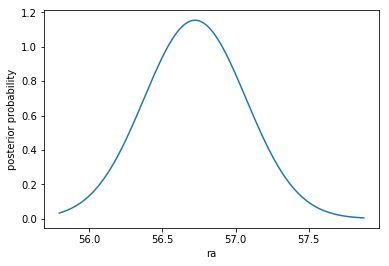

best dec: 24.015777687711207
68 percent interval: 23.933463006939636 to 24.096685279922582


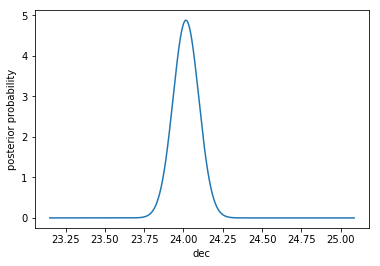

In [11]:
#pleiades_members = cat_pr.find_cluster_members(clusters_data[2], ['pmra','pmdec','radial_distance'])
#clustervis = Visualization(pleiades_members, ra_cen, dec_cen)
#clustervis.plot('pmra','pmdec')
#print(len(clusters_data[2][0]))
#print(clusters_data[2])
for cluster in clusters_data:
    cat_pr.cluster_stats(cluster)

551
Added gaia coords!
fetching surveys:
['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22']
with radius:
2d04m34.6477s


<IPython.core.display.Javascript object>


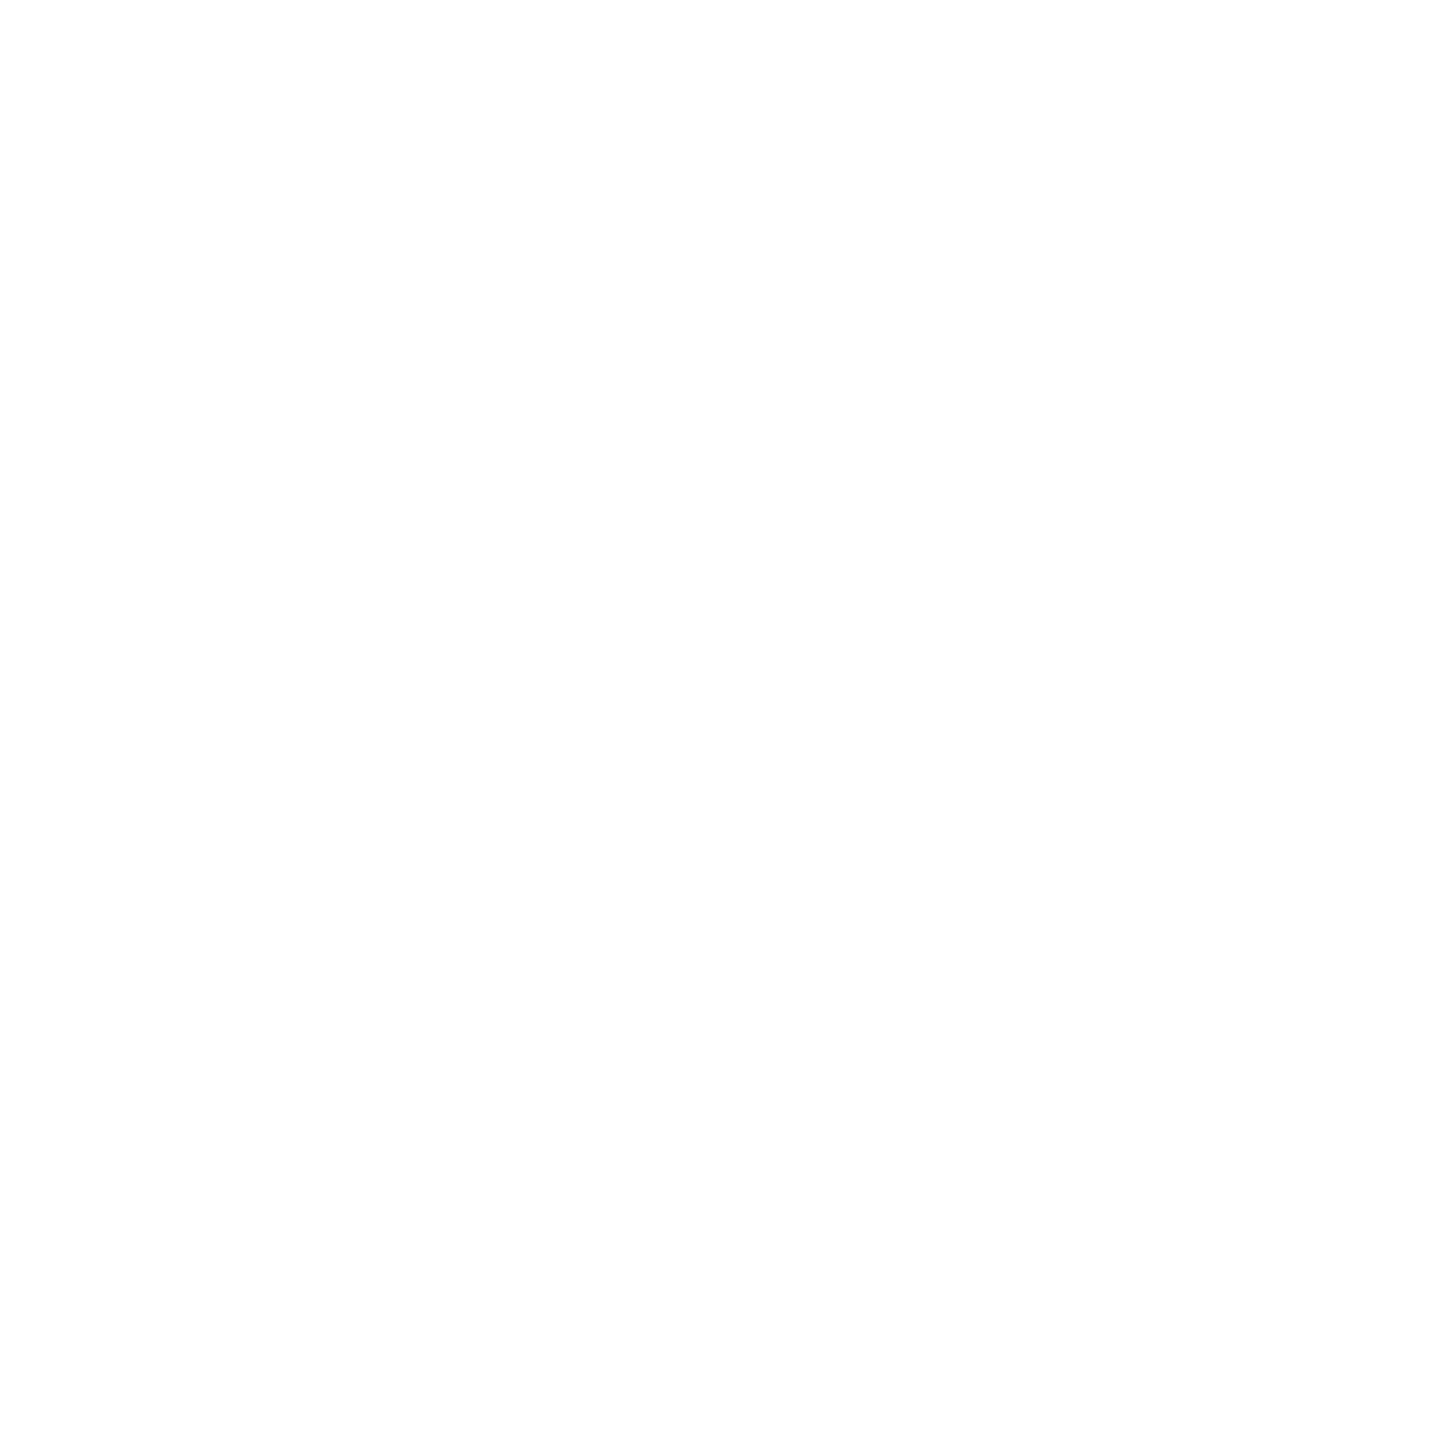

<IPython.core.display.Javascript object>


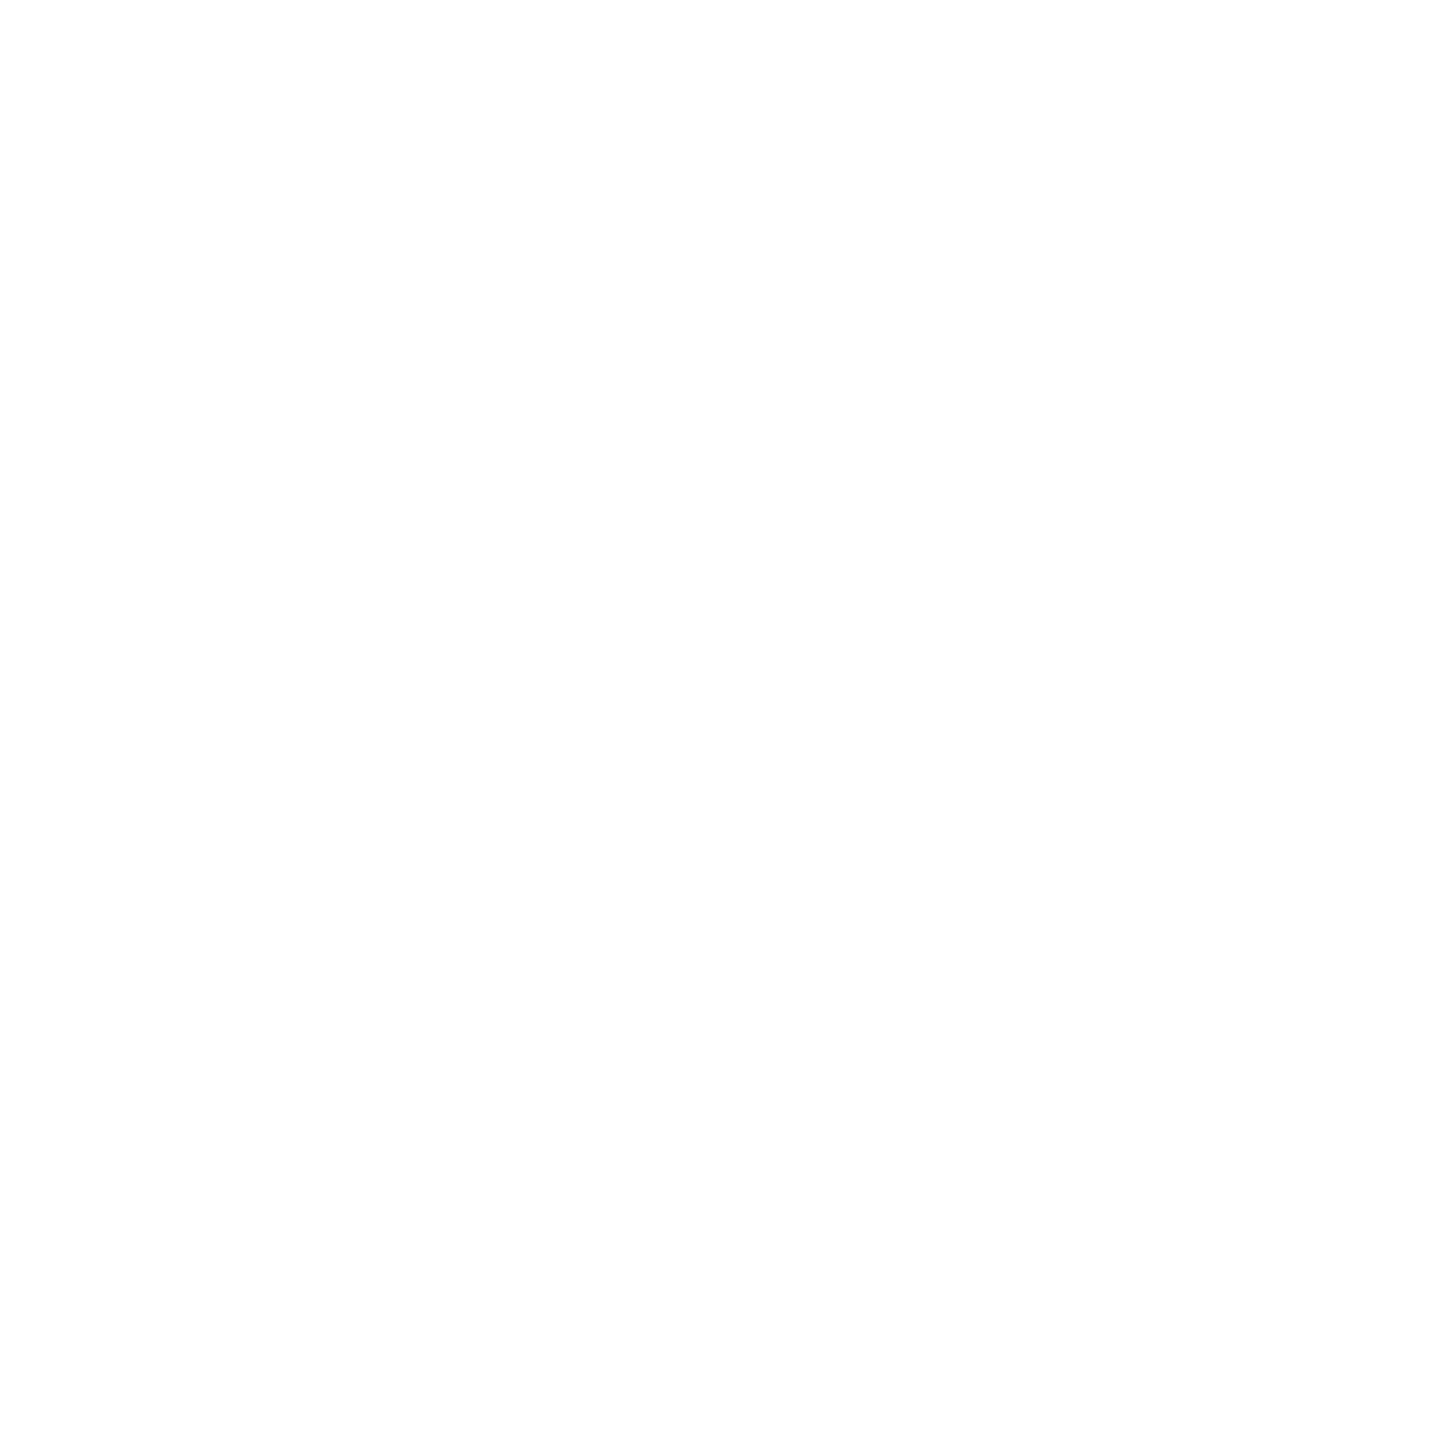

In [12]:
print(len(clusters_data[0]['gaia_ra']))
%matplotlib notebook
vis2 = Visualization(clusters_data[0], ra_cen, dec_cen)
vis2.plot_images(['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22'], cats_to_plot=["gaia"])

In [13]:
inpleiadesrange, outpleiadesrange = phot.apply_cut('self.full_table["parallax"] > 5')

The cells below apply cuts that select certain parallax ranges. With the parallax constrained, the clustering seems to be much clearer. Again, the Pleiades are identifed, but I think some of the stars identified with the cluster are not in fact part of it. That's part of why I want to incorporate additional columns like parallax in the clustering.

Organizing clustering data...
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'gaia_ra', 'ra_error', 'gaia_dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'p

<IPython.core.display.Javascript object>


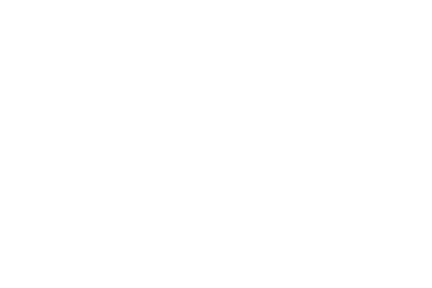

plotting cluster0


<IPython.core.display.Javascript object>


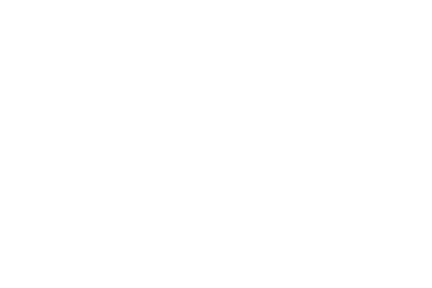

plotting cluster1


<IPython.core.display.Javascript object>


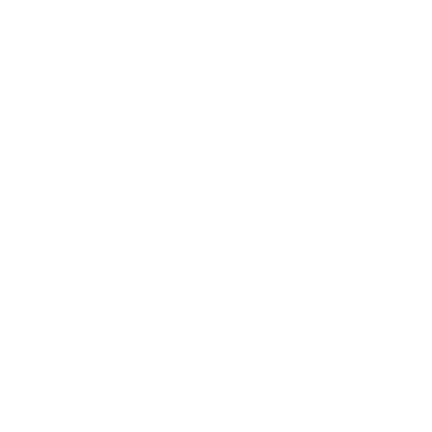

<IPython.core.display.Javascript object>


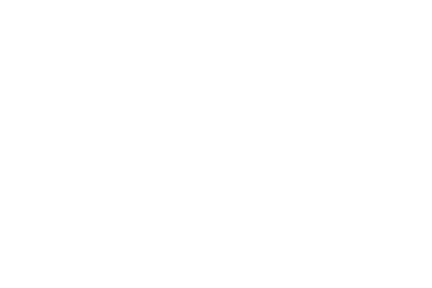

<IPython.core.display.Javascript object>


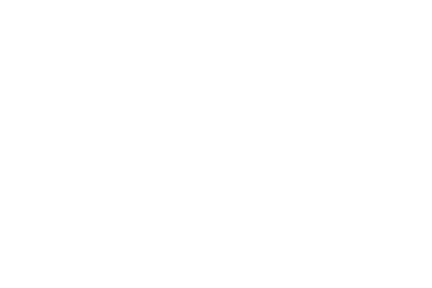

<IPython.core.display.Javascript object>


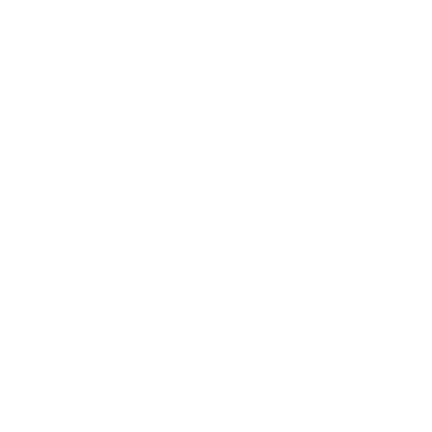

In [14]:
candidates_table, cluster_membership = cat_pr.identify_clusters(inpleiadesrange, ["pmra","pmdec"], expected_clusters = 2)
vis.plot_clusters(candidates_table, cluster_membership, column_A="pmra", column_B="pmdec")

Organizing clustering data...
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'gaia_ra', 'ra_error', 'gaia_dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'p

<IPython.core.display.Javascript object>


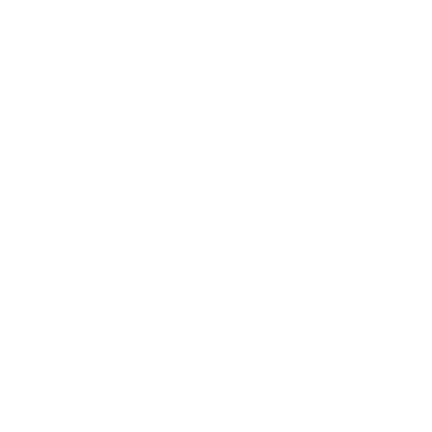

NameError: name 'car_pr' is not defined

<IPython.core.display.Javascript object>


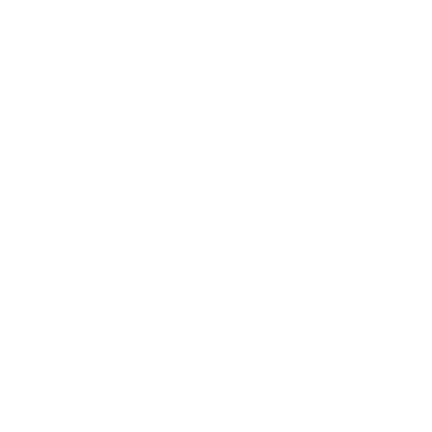

In [15]:
candidates_table, cluster_membership = cat_pr.identify_clusters(inpleiadesrange, ["pmra","pmdec"], expected_clusters = 1)
vis.plot_clusters(candidates_table, cluster_membership, column_A="pmra", column_B="pmdec")
clusters_list = car_pr.process_clusters(candidates_table, cluster_membership)

In [ ]:
inlargerrange, outlargerrange = phot.apply_cut('self.full_table["parallax"] > 2 and self.full_table["parallax"] < 5.5')

In [ ]:
candidates_table, cluster_membership = cat_pr.identify_clusters(inlargerrange, ["pmra","pmdec","radial_distance", "gaia_ra", "gaia_dec"])
vis.plot_clusters(candidates_table, cluster_membership, column_A="pmra", column_B="pmdec")

In [ ]:
candidates_table, cluster_membership = cat_pr.identify_clusters(inlargerrange, ["pmra","pmdec"], expected_clusters = 2)
vis.plot_clusters(candidates_table, cluster_membership, column_A="pmra", column_B="pmdec")

In [ ]:
print(max(cluster_membership))

In [ ]:
print(np.mean(candidates_table['pmra']))